# Coronavirus Disease (COVID-19) Situation Reports

In this notebook we will show the development process for a model that classifies the evolution curve of a country, in terms of the number of COVID-19 cases over time.

## Step 1 - Handling Data

Before anything else, we must handle the raw data of the dataset we're using, so as to fit them to the model we want to implement.

### 1.1 - Reading Data

For reading the raw dataset, we used the `pandas` library, as recommended in the class Lectures.

In [10]:
# Defining Global Variables
DATA_FOLDER = 'data'
WORLD_DATA_FILE = 'world-data.csv'

# import the necessary dependencies
import pandas as pd

In order to properly read the dates, we must declare a custom function to parse the input data. (More information [here](https://stackoverflow.com/questions/17465045/can-pandas-automatically-recognize-dates)).

In [3]:
# creating custom date parser (mm/dd/yy)
from datetime import datetime
custom_date_parser = lambda x: datetime.strptime(x, '%m/%d/%y')

We can now read the csv file, in order to import our dataset.

In [4]:
# read csv
covid_world_dataframe = pd.read_csv(f'{DATA_FOLDER}/{WORLD_DATA_FILE}', parse_dates=['Date'], date_parser=custom_date_parser)
covid_world_dataframe.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


### 1.2 - Data Pre-Processing

#### Problems

- Some Countries do not have a `Province/State`
- Those that have a `Province/State` also present different `Lat` and `Long` coordinates
- The ones that have a `Province/State` also have the data for `Confirmed`, `Deaths` and `Recovered` for that specific `Province/State`

#### Solution

- Group the data by `Country/Region` and `Date`
- Calculate the average within each Country
- Add up all of the cases for each `Province/State` and set that as the country's value

In [6]:
# remove 'Province/State' column
covid_world_dataframe = covid_world_dataframe.drop(labels=['Province/State'], axis=1)
covid_world_dataframe.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [9]:
# Calculate new 'Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered'
aggregation_functions = {
    # Calculate the average latitude and longitude
    'Lat': 'mean',
    'Long': 'mean',
    # Calculate the sum of confirmed cases, deaths and recovered of the day
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}
# group by country and date
covid_world_dataframe = covid_world_dataframe.groupby(['Date', 'Country/Region']).aggregate(aggregation_functions)
covid_world_dataframe.head()

Lat     Long  Confirmed  Deaths  Recovered
Date       Country/Region                                                
2020-01-22 Afghanistan     33.0000  65.0000          0       0          0
           Albania         41.1533  20.1683          0       0          0
           Algeria         28.0339   1.6596          0       0          0
           Andorra         42.5063   1.5218          0       0          0
           Angola         -11.2027  17.8739          0       0          0

Because of `groupby(['Date', 'Country/Region'])`, the index of the tables is the multi-index `[Date, Country/Region]`. To return to the initial state, we must reset the indices. For this, we can have two approaches:

Option 1) Removing a specific index (in this case, `Country/Region`):
```python
covid_world_dataframe = covid_world_dataframe.reset_index(level=['Country/Region'])
```

Option 2) Removing all indices:
```python
covid_world_dataframe = covid_world_dataframe.reset_index()
# or
covid_world_dataframe.reset_index(inplace=True)
```

In [11]:
covid_world_dataframe = covid_world_dataframe.reset_index()
covid_world_dataframe.head()

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
0,2020-01-22,Afghanistan,33.0000,65.0000,0,0,0
1,2020-01-22,Albania,41.1533,20.1683,0,0,0
2,2020-01-22,Algeria,28.0339,1.6596,0,0,0
3,2020-01-22,Andorra,42.5063,1.5218,0,0,0
4,2020-01-22,Angola,-11.2027,17.8739,0,0,0


### 1.3 - Data Filtering

For demonstration purposes, we will filter the data relative to `China`, `Portugal`, the United States (`US`) and the `United Kingdom`.

In [12]:
# filter
countries = ['US', 'United Kingdom', 'China', 'Portugal']
covid_filtered_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'].isin(countries)]
covid_filtered_dataframe.head(8)

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
36,2020-01-22,China,32.828385,111.649082,548,17,28
136,2020-01-22,Portugal,39.399900,-8.224500,0,0,0
174,2020-01-22,US,37.090200,-95.712900,1,0,0
178,2020-01-22,United Kingdom,24.548173,-43.902245,0,0,0
224,2020-01-23,China,32.828385,111.649082,643,18,30
324,2020-01-23,Portugal,39.399900,-8.224500,0,0,0
362,2020-01-23,US,37.090200,-95.712900,1,0,0
366,2020-01-23,United Kingdom,24.548173,-43.902245,0,0,0


### 1.4 - Plotting

With our new filtered data, we will use [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html), so as to be able to compare the `Confirmed`, `Deaths` and `Recovered` values.

**Note:** For our plotting, we are using `seaborn`, as `matplotlib` does not handle dates very well (information [here](https://matplotlib.org/3.1.1/gallery/recipes/common_date_problems.html)).

In [14]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

''

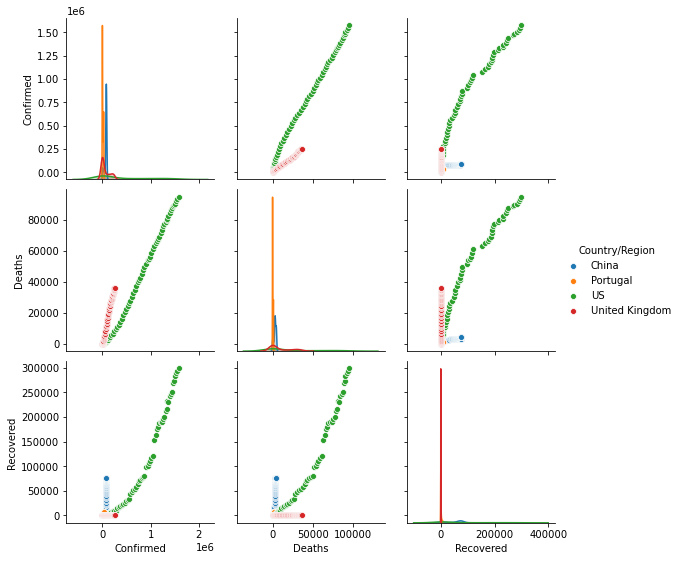

In [16]:
# plot
import matplotlib.pyplot as plt
import seaborn as sb
sb.pairplot(covid_filtered_dataframe, hue='Country/Region', vars=['Confirmed', 'Deaths', 'Recovered'])
;

Let's now compare the data in `Portugal`, over time:

In [17]:
# create portugal dataframe
covid_portugal_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'Portugal']
covid_portugal_dataframe.head()

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
136,2020-01-22,Portugal,39.3999,-8.2245,0,0,0
324,2020-01-23,Portugal,39.3999,-8.2245,0,0,0
512,2020-01-24,Portugal,39.3999,-8.2245,0,0,0
700,2020-01-25,Portugal,39.3999,-8.2245,0,0,0
888,2020-01-26,Portugal,39.3999,-8.2245,0,0,0


The most direct way to use the dates as the horizontal axis is to simply make them an index, which makes sense, as the dates are unique for each country.

In [18]:
# set date as index and drop column
covid_portugal_dataframe.set_index('Date', inplace=True, drop=True)
covid_portugal_dataframe.head()

,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,,
2020-01-22,Portugal,39.3999,-8.2245,0,0,0
2020-01-23,Portugal,39.3999,-8.2245,0,0,0
2020-01-24,Portugal,39.3999,-8.2245,0,0,0
2020-01-25,Portugal,39.3999,-8.2245,0,0,0
2020-01-26,Portugal,39.3999,-8.2245,0,0,0


''

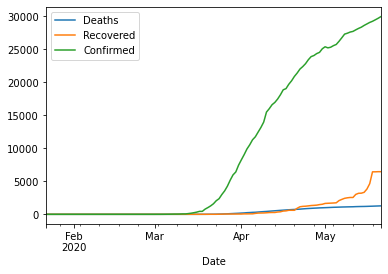

In [19]:
covid_portugal_dataframe[['Deaths', 'Recovered', 'Confirmed']].plot()
;

However, if we explicitly desire to use `seaborn`, which we do, we should reset the index and use the `melt` method:

In [20]:
covid_portugal_dataframe = covid_portugal_dataframe.reset_index()
covid_portugal_dataframe.head()

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
0,2020-01-22,Portugal,39.3999,-8.2245,0,0,0
1,2020-01-23,Portugal,39.3999,-8.2245,0,0,0
2,2020-01-24,Portugal,39.3999,-8.2245,0,0,0
3,2020-01-25,Portugal,39.3999,-8.2245,0,0,0
4,2020-01-26,Portugal,39.3999,-8.2245,0,0,0


In [21]:
covid_portugal_dataframe_melt = pd.melt(covid_portugal_dataframe, ['Date', 'Country/Region', 'Lat', 'Long'], value_name='Count')
covid_portugal_dataframe_melt

,Date,Country/Region,Lat,Long,variable,Count
0,2020-01-22,Portugal,39.3999,-8.2245,Confirmed,0
1,2020-01-23,Portugal,39.3999,-8.2245,Confirmed,0
2,2020-01-24,Portugal,39.3999,-8.2245,Confirmed,0
3,2020-01-25,Portugal,39.3999,-8.2245,Confirmed,0
4,2020-01-26,Portugal,39.3999,-8.2245,Confirmed,0
...,...,...,...,...,...,...
358,2020-05-17,Portugal,39.3999,-8.2245,Recovered,4636
359,2020-05-18,Portugal,39.3999,-8.2245,Recovered,6430
360,2020-05-19,Portugal,39.3999,-8.2245,Recovered,6431
361,2020-05-20,Portugal,39.3999,-8.2245,Recovered,6452


''

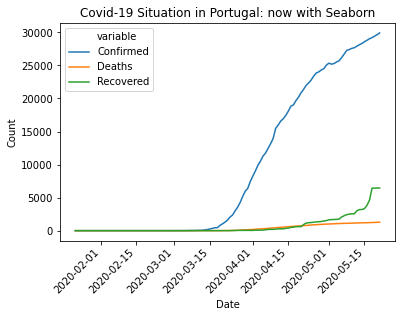

In [22]:
ax = sb.lineplot(x='Date', y='Count', hue='variable', data=covid_portugal_dataframe_melt)
ax.set_title('Covid-19 Situation in Portugal: now with Seaborn')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
;

We can also see the plot for each of the variables separately, using `seaborn`:

''

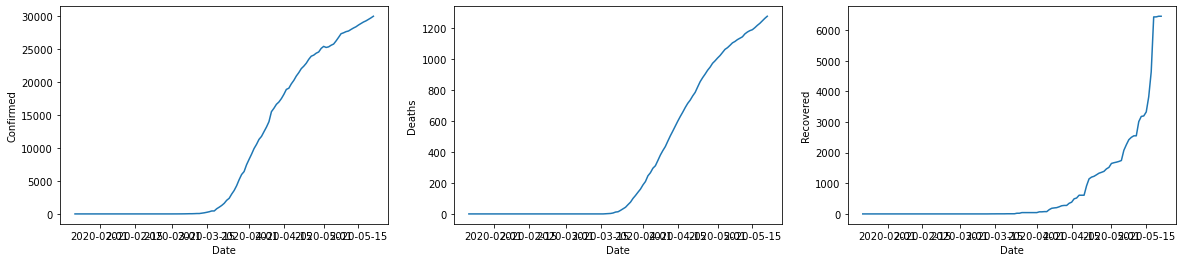

In [23]:
# criar area de plot
plt.figure(figsize=(20, 4))
# subplot de confirmed
plt.subplot(1, 3, 1)
sb.lineplot(x='Date', y='Confirmed', data=covid_portugal_dataframe)
# subplot de deaths
plt.subplot(1, 3, 2)
sb.lineplot(x='Date', y='Deaths', data=covid_portugal_dataframe)
# subplot de recovered
plt.subplot(1, 3, 3)
sb.lineplot(x='Date', y='Recovered', data=covid_portugal_dataframe)
# mostrar plot (nao necessario)
plt.draw()
;

Let's now compare the data of the 4 countries that were initially filtered:

In [24]:
# create new dataset for chosen countries
confirmed_dataframe = covid_filtered_dataframe[['Date']].copy()
confirmed_dataframe.drop_duplicates(inplace=True)

def get_country_victims(country: str, victims: str):
    return covid_filtered_dataframe.loc[covid_filtered_dataframe['Country/Region'] == country , victims].tolist()

Comparing the confirmed cases between the 4 countries:

In [25]:
confirmed_dataframe['Portugal'] = get_country_victims('Portugal', 'Confirmed')
confirmed_dataframe['US'] = get_country_victims('US', 'Confirmed')
confirmed_dataframe['United Kingdom'] = get_country_victims('United Kingdom', 'Confirmed')
confirmed_dataframe['China'] = get_country_victims('China', 'Confirmed')
confirmed_dataframe

,Date,Portugal,US,United Kingdom,China
36,2020-01-22,0,1,0,548
224,2020-01-23,0,1,0,643
412,2020-01-24,0,2,0,920
600,2020-01-25,0,2,0,1406
788,2020-01-26,0,5,0,2075
...,...,...,...,...,...
21844,2020-05-17,29036,1486757,244995,84054
22032,2020-05-18,29209,1508308,247709,84063
22220,2020-05-19,29432,1528568,250138,84063
22408,2020-05-20,29660,1551853,249619,84063


It's easier to compare the data by visualizing it graphically. Therefore we can draw the plot for the evolution of this variable in the 4 countries:

''

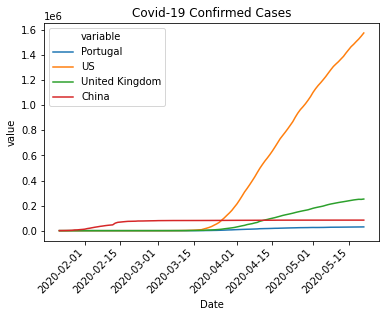

In [26]:
confirmed_dataframe_melt = pd.melt(confirmed_dataframe, ['Date'])
ax = sb.lineplot(x='Date', y='value', hue='variable', data=confirmed_dataframe_melt)
ax.set_title('Covid-19 Confirmed Cases')
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
;

Now, let's visualize the curve of the confirmed cases in these 4 countries.

First, we must create the dataframes for the `US`, the `United Kingdom` and `China`, as the dataframe for `Portugal` has already been created.

In [27]:
# create US dataframe
covid_us_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'US']
# create UK dataframe
covid_uk_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'United Kingdom']
# create China dataframe
covid_china_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'China']

''

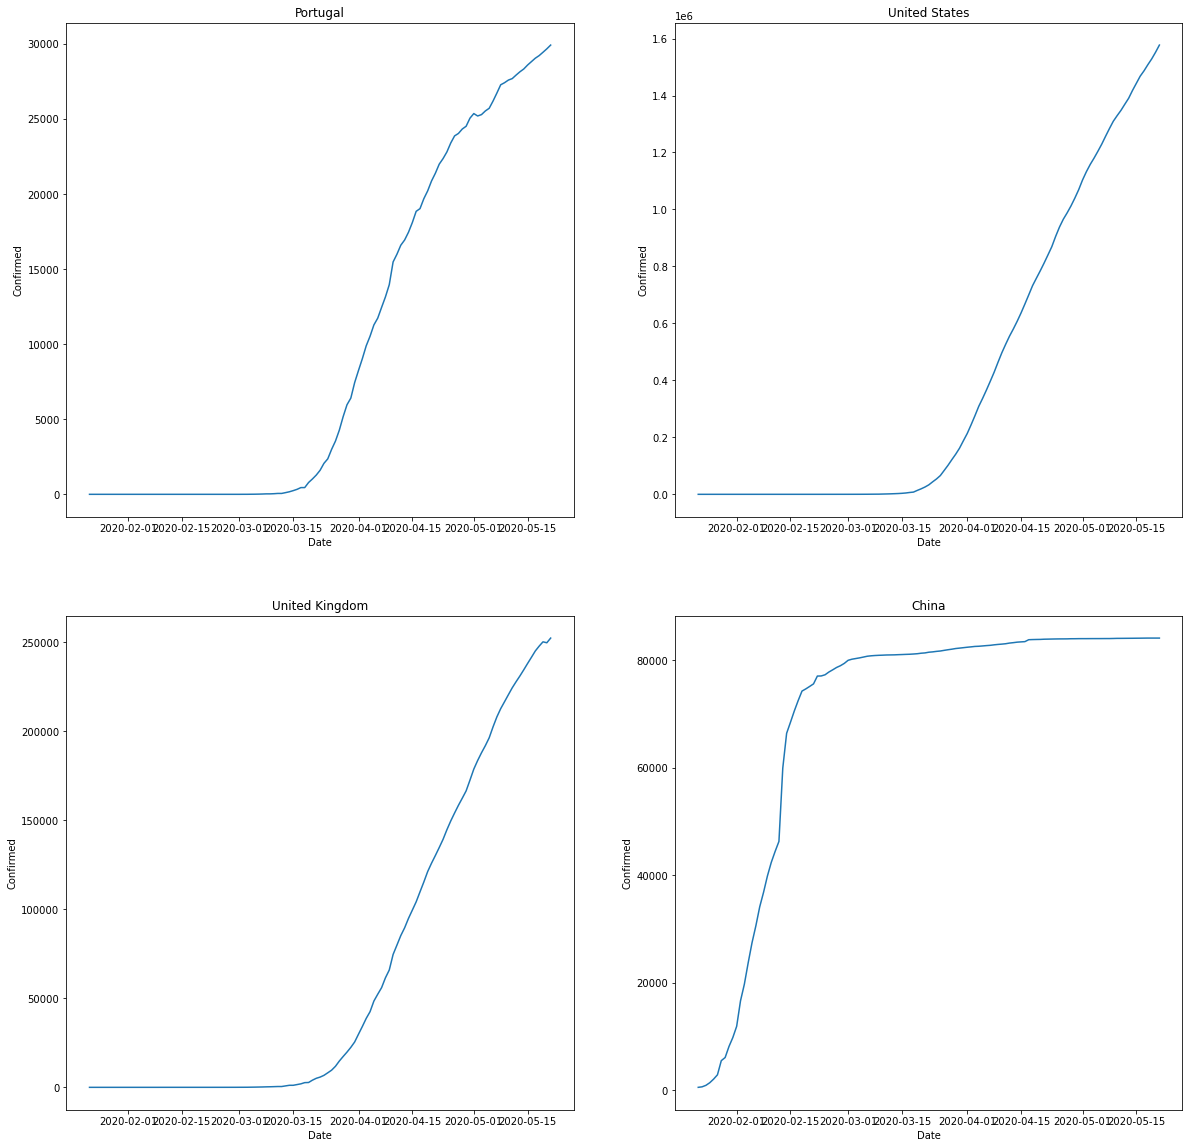

In [28]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
sb.lineplot(x='Date', y='Confirmed', data=covid_portugal_dataframe).set_title('Portugal')
plt.subplot(2, 2, 2)
sb.lineplot(x='Date', y='Confirmed', data=covid_us_dataframe).set_title('United States')
plt.subplot(2, 2, 3)
sb.lineplot(x='Date', y='Confirmed', data=covid_uk_dataframe).set_title('United Kingdom')
plt.subplot(2, 2, 4)
sb.lineplot(x='Date', y='Confirmed', data=covid_china_dataframe).set_title('China')
;

This concludes the first section of our project. We can now advance to the implementation of Unsupervised Learning.

--------------------------------------

## Step 2 - Clustering

**SOURCE:** https://towardsdatascience.com/classify-growth-patterns-for-covid-19-data-41af4c7adc55

**GITHUB:** https://github.com/Perishleaf/data-visualisation-scripts/blob/master/coronavirus_country_PCoA/COVID-19_analysis.ipynb

Regardless of what we have done so far, visual differentiation of these many curves is rather difficult. It is better to classify these curves into clusters, in which similar curves are classified as the same group. Here, we combined **Principle Coordinates Analysis (PCA)** with **K-means Clustering**, to plot similarities/relatedness between the incremental patterns of countries/regions, on a 2D referential, and classify them into groups.

In a nutshell, nearby circles (i.e. countries/regions) in 2D ordination should have similar growth patterns, while circles which are far apart share few similarities.

To start things off, let's reverse our dataframe, so that the Countries are now the columns ([source](https://stackoverflow.com/questions/17298313/python-pandas-convert-rows-as-column-headers)):

In [29]:
# we dont need to remove unused columns, pivot_table already does that
'''
# remove lat, long, deaths and recovered
new_dataframe = covid_world_dataframe.drop(labels=['Lat', 'Long', 'Deaths', 'Recovered'], axis=1)
new_dataframe
'''
new_dataframe = covid_world_dataframe.pivot_table('Confirmed', ['Date'], 'Country/Region')
new_dataframe

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,6664,946,7019,761,48,25,8068,4472,7054,16242,...,244995,734,2753,541,320,381,6,128,753,44
2020-05-18,7072,948,7201,761,50,25,8371,4823,7068,16269,...,247709,737,2791,618,324,388,6,130,761,46
2020-05-19,7653,949,7377,761,52,25,8809,5041,7072,16321,...,250138,738,2855,749,324,391,6,167,772,46


Now, as we can clearly see, we have **121 days** and **188 countries**.

#### Problem

- Data is cumulative

#### Solution

- Let's make our data differential ([source](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html))

In [30]:
# store first row
first_row = new_dataframe.iloc[0]
new_dataframe = new_dataframe.diff()
new_dataframe.iloc[0] = first_row
new_dataframe

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-17,262.0,13.0,198.0,0.0,0.0,0.0,263.0,189.0,10.0,41.0,...,3534.0,1.0,15.0,37.0,2.0,5.0,0.0,6.0,74.0,2.0
2020-05-18,408.0,2.0,182.0,0.0,2.0,0.0,303.0,351.0,14.0,27.0,...,2714.0,3.0,38.0,77.0,4.0,7.0,0.0,2.0,8.0,2.0
2020-05-19,581.0,1.0,176.0,0.0,2.0,0.0,438.0,218.0,4.0,52.0,...,2429.0,1.0,64.0,131.0,0.0,3.0,0.0,37.0,11.0,0.0


--------------------------------------

''

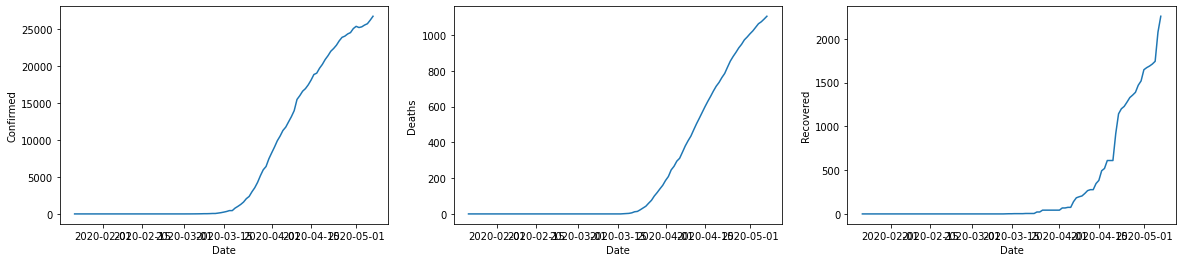

In [220]:
plt.figure(figsize=(20, 4))

covid_portugal_dataframe = df_new.loc[df_new['Country/Region'] == 'Portugal']

plt.subplot(1, 3, 1)
sb.lineplot(x=covid_portugal_dataframe.index, y='Confirmed', data=covid_portugal_dataframe)
plt.subplot(1, 3, 2)
sb.lineplot(x=covid_portugal_dataframe.index, y='Deaths', data=covid_portugal_dataframe)
plt.subplot(1, 3, 3)
sb.lineplot(x=covid_portugal_dataframe.index, y='Recovered', data=covid_portugal_dataframe)
;

In [241]:
test = covid_portugal_dataframe.reset_index()
test = pd.melt(test, ['Date'])
test

,Date,variable,value
0,2020-01-22,Country/Region,Portugal
1,2020-01-23,Country/Region,Portugal
2,2020-01-24,Country/Region,Portugal
3,2020-01-25,Country/Region,Portugal
4,2020-01-26,Country/Region,Portugal
...,...,...,...
637,2020-05-03,Recovered,1689
638,2020-05-04,Recovered,1712
639,2020-05-05,Recovered,1743
640,2020-05-06,Recovered,2076


## Portugal Data from World Dataset

In [27]:
# create portgual dataframe
covid_portugal_dataframe = covid_world_dataframe.loc[covid_world_dataframe['Country/Region'] == 'Portugal']
covid_portugal_dataframe.head()

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
184,Portugal,39.3999,-8.2245,2020-01-22,0,0,0
448,Portugal,39.3999,-8.2245,2020-01-23,0,0,0
712,Portugal,39.3999,-8.2245,2020-01-24,0,0,0
976,Portugal,39.3999,-8.2245,2020-01-25,0,0,0
1240,Portugal,39.3999,-8.2245,2020-01-26,0,0,0


In [28]:
# set date as index and drop column
covid_portugal_dataframe.set_index('Date', inplace=True, drop=True)
covid_portugal_dataframe.head()

,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,,
2020-01-22,Portugal,39.3999,-8.2245,0,0,0
2020-01-23,Portugal,39.3999,-8.2245,0,0,0
2020-01-24,Portugal,39.3999,-8.2245,0,0,0
2020-01-25,Portugal,39.3999,-8.2245,0,0,0
2020-01-26,Portugal,39.3999,-8.2245,0,0,0


''

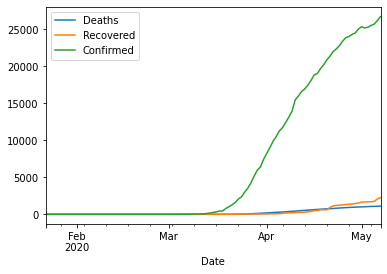

In [29]:
covid_portugal_dataframe[['Deaths', 'Recovered', 'Confirmed']].plot()
;